# Asian Call

@Author: Daniel Rodriguez Delgado

@Date: 28/01/2019

In [1]:
from math import *
import numpy as np
import pandas as pd
from scipy.stats import kurtosis, skew, pearsonr, norm, t
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'


## 1. Pseudo-random number generators

In [2]:
def congru(seed, m=((2**31)-1), a=16807, b=0):
        y=(a*seed+b)%m
        u=y/m
        return(u, y)
    
def boxmuller(seed, mu=0, sigma=1):
    u1, seed=congru(seed)    #Uniform inputs
    u2, seed=congru(seed)
    
    x=sqrt(-2*log(u1))*cos(2*pi*u2)*sigma+mu  #Gaussian numbers generation
    y=sqrt(-2*log(u1))*sin(2*pi*u2)*sigma+mu
    
    antx=sqrt(-2*log(1-u1))*cos(2*pi*(1-u2))*sigma+mu  #Antithetic numbers generation
    anty=sqrt(-2*log(1-u1))*sin(2*pi*(1-u2))*sigma+mu
    return(x, y, u1, u2, antx, anty, seed)


def marsaglia(seed, mu=0, sigma=1, mode='normal'):
    
    while True:
        if mode=='normal':
            u1, seed= congru(seed)
            u2, seed= congru(seed)
            v1=2*u1-1
            v2=2*u2-1
            R2=v1**2+v2**2
            if R2<=1:
                y=sqrt(-2*log(R2)/R2)
                x1=v1*y*sigma+mu
                x2=v2*y*sigma+mu
                break
        if mode=='antithetic':
            u1, seed= congru(seed)
            u2, seed= congru(seed)
            v1=2*(1-u1)-1
            v2=2*(1-u2)-1
            R2=v1**2+v2**2
            if R2<=1:
                y=sqrt(-2*log(R2)/R2)
                x1=v1*y*sigma+mu
                x2=v2*y*sigma+mu
                break
        
    return(x1,x2,seed)

# Gamma distribution random generator
def gamma (p, a, seed):
    v=[]
    for i in range(p):
        u, seed= congru(seed)
        v.append(log(u))
    x=-sum(v)/a
    return(x, seed)


# Chi^2 distribution random generator
def chisq (n, seed):
    if (n%2==0):
        g, seed=gamma(int(n/2), 1/2, seed)
        return(g, seed)
    else:
        g, seed=gamma(int((n-1)/2), 1/2, seed)
        cos1, sen1, u1, u2, antx, anty, seed = boxmuller(seed)
        x=g+sen1**2
    return(x, seed)

# t-student distribution random generator
def tstudent (n, seed):
    cos1, sen1, u1, u2, antx, anty, seed=boxmuller(seed)
    xchi, seed=chisq(n, seed)
    x=sen1/sqrt(xchi/n)
    return(x, seed)


## 2. Random numbers

For this time, random numbers will be generated according to a Gaussian distribution with $\mu=0$ and $\sigma=1$ by Box-Müller sine method.

In [13]:
N=12012
BMsen=[]
seed=123456789

for i in range(N):
    x, y, u1, u2, antx, anty, seed = boxmuller(seed, mu=0, sigma=1)
    BMsen.append(y)


## 3. Initial Data

In [14]:
# Underlying price at the begining
S0=14
# Strike price
Str=14

# Yearly and continous return
ry=0.03
rc=log(1+ry)

# Yearly and continuos discount rate
dy=0
dc=log(1+dy)

# Volatility
sig=0.3
#Period
T=1

## 4. Pricing asian call

This time, the equation used to get an approximation of both asian put and asian call prices was the following:
\begin{equation}
S \leftarrow S(1+r-d)^{\Delta t}+\sigma S \sqrt{\Delta t}\cdot \mathcal{N}(0,1)
\end{equation}

As well the pay-off has been calculated by getting the average of it along the 12 months period for each scenario, in order to, eventually, calculate the average pay-off of the 1000 scenarios. The equation to obtain the both options value is:
\begin{equation}
Value_{mean}=payoff\cdot e^{-rc\cdot T}
\end{equation}


In [17]:
d=12
dt=T/d

tM=np.empty((0,d+1))
# Expected pay-off for 12 months and 1000 simulations
payoff12c=[]
payoff12p=[]

for index, iem in enumerate(range(1,1001)):
    tm=[S0]
    j=index
    for i in range(d):
        if (i<1):
            te=S0*(1+ry-dc)**dt+sig*S0*np.sqrt(dt)* BMsen[i+j*12]
            tm.append(te)
#             display(BMsen[i],S0,ry,dc,dt,sig)
        else:
#             display(BMsen[i],te,ry,dc,dt,sig)
            te=te*(1+ry-dc)**dt+sig*te*np.sqrt(dt)* BMsen[i+j*12]
            tm.append(te)
            
    tm=np.array(tm)    
    tM=np.vstack((tM,tm))
    
    if (np.mean(tm)>Str):
        payoff12c.append(np.mean(tm)-Str)
        payoff12p.append(0)
    else:
        payoff12c.append(0)
        payoff12p.append(Str-np.mean(tm))

# Pay-off 12 months metrics for call option
po12AVGc=np.mean(payoff12c)
po12VARc=np.var(payoff12c, ddof=1)
po12ACCc=t.ppf(1-0.05/2,len(tM))*np.sqrt(po12VARc/1000)

val12AVGc=po12AVGc*np.exp(-rc*T)
val12VARc=po12VARc*np.exp(-2*rc*T)
val12ACCc=t.ppf(1-0.05/2,len(tM))*np.sqrt(val12VARc/1000)

index=['mean', 'variance', 'accuracy']
metricsc=pd.DataFrame({
                      'Pay-off': np.array([po12AVGc, po12VARc, po12ACCc]),
                      'Value': np.array([val12AVGc, val12VARc, val12ACCc])
                    }, index=index)


# Pay-off 12 months metrics for put option
po12AVGp=np.mean(payoff12p)
po12VARp=np.var(payoff12p, ddof=1)
po12ACCp=t.ppf(1-0.05/2,len(tM))*np.sqrt(po12VARp/N)

val12AVGp=po12AVGp*np.exp(-rc*T)
val12VARp=po12VARp*np.exp(-2*rc*T)
val12ACCp=t.ppf(1-0.05/2,len(tM))*np.sqrt(val12VARp/N)

index=['mean', 'variance', 'accuracy']
metricsp=pd.DataFrame({
                      'Pay-off': np.array([po12AVGp, po12VARp, po12ACCp]),
                      'Value': np.array([val12AVGp, val12VARp, val12ACCp])
                    }, index=index)

print('')
print(color.BOLD + 'Metrics for call option:')
display( metricsc)
print('')
print(color.BOLD + 'Metrics for put option:')
display(metricsp)


Metrics for call option:


,Pay-off,Value
mean,1.153443,1.119848
variance,2.932987,2.764621
accuracy,0.106275,0.103179



Metrics for put option:


,Pay-off,Value
mean,0.794327,0.771191
variance,1.290389,1.216316
accuracy,0.009770,0.009486


### 5. Underlying simulation chart

Text(0, 0.5, 'Underlying evolution')

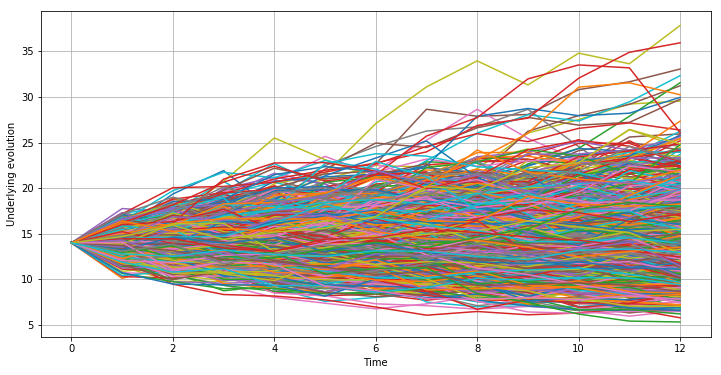

In [18]:
    
plt.figure(figsize=(12,6))
ejex=range(12)
plt.plot(np.matrix.transpose(tM))
plt.grid()
plt.xlabel('Time')
plt.ylabel('Underlying evolution')

